#### Customized_Tools

In [11]:
import os,sys
sys.path.insert(0,'../../libs')
from utils import load_json

### Load all API keys 
openai_key = load_json('/home/chengyu.huang/project/Fund_projects/openai_key.json') 
os.environ['OPENAI_API_KEY'] = openai_key['ChatGPT']['API_KEY']

- Here is how we create a new customized tools 

In [12]:
from langchain.tools import BaseTool
from math import pi
from typing import Union

## let's create a calculate circumference tool 
class CircumferenceTool(BaseTool):
    name = "Circumference calculator"
    description = "use this tool when you need to calculate a circumference using the radius of a circle"

    def _run(self, radius: Union[int, float]):
        return float(radius)*2.0*pi

    def _arun(self, radius: int):
        raise NotImplementedError("This tool does not support async")

- now let's create a converstaion agent 

In [13]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory


# initialize LLM (we use ChatOpenAI because we'll later define a `chat` agent)
llm = ChatOpenAI(
        openai_api_key=os.environ['OPENAI_API_KEY'],
        temperature=0,
        model_name='gpt-3.5-turbo'
)

# initialize conversational memory
conversational_memory = ConversationBufferWindowMemory(
        memory_key='chat_history',
        k=5,      ## limit it to 5 turns of conversion 
        return_messages=True
)



- initiate agent with customized tool 

In [14]:
from langchain.agents import initialize_agent

tools = [CircumferenceTool()]

# initialize agent with tools
agent = initialize_agent(
    agent='chat-conversational-react-description', # use conversional memory,use react mechanism and use description to use tool 
    tools=tools,
    llm=llm,
    verbose=True,                                  # show log
    max_iterations=3,                              # how many reasoning steps we allow 
    early_stopping_method='generate',              # model decide when to stop 
    memory=conversational_memory
)

In [16]:
agent("can you calculate the circumference of a circle that has a radius of 7.81mm")




> Entering new AgentExecutor chain...
{
    "action": "Circumference calculator",
    "action_input": "7.81"
}
Observation: 49.071677249072565
Thought:{
    "action": "Final Answer",
    "action_input": "The circumference of a circle with a radius of 7.81mm is approximately 49.07mm."
}

> Finished chain.


{'input': 'can you calculate the circumference of a circle that has a radius of 7.81mm',
 'chat_history': [],
 'output': 'The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.'}

- if the agent did not use the tool, but direcately use an LLM. we can change the system message the let it konw it can't do math 

In [18]:
# existing prompt
print(agent.agent.llm_chain.prompt.messages[0].prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of task

In [19]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Unfortunately, Assistant is terrible at maths. When provided with math questions, no matter how simple, assistant always refers to it's trusty tools and absolutely does NOT try to answer math questions by itself

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

In [20]:
## update system message 
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt

In [21]:
agent("can you calculate the circumference of a circle that has a radius of 7.81mm")




> Entering new AgentExecutor chain...
```json
{
    "action": "Circumference calculator",
    "action_input": "7.81"
}
```
Observation: 49.071677249072565
Thought:```json
{
    "action": "Final Answer",
    "action_input": "The circumference of a circle with a radius of 7.81mm is approximately 49.07mm."
}
```

> Finished chain.


{'input': 'can you calculate the circumference of a circle that has a radius of 7.81mm',
 'chat_history': [HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False)],
 'output': 'The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.'}

### Tools With Multiple Parameters

- We want multiple inputs here because we calculate the triangle hypotenuse with different values (the sides and angle). Additionally, we don’t need all values. We can calculate the hypotenuse with any combination of two or more parameters

In [22]:
from typing import Optional
from math import sqrt, cos, sin

desc = (
    "use this tool when you need to calculate the length of a hypotenuse"
    "given one or two sides of a triangle and/or an angle (in degrees). "
    "To use the tool, you must provide at least two of the following parameters "
    "['adjacent_side', 'opposite_side', 'angle']."
)

class PythagorasTool(BaseTool):
    name = "Hypotenuse calculator"
    description = desc
    
    def _run(
        self,
        adjacent_side: Optional[Union[int, float]] = None,
        opposite_side: Optional[Union[int, float]] = None,
        angle: Optional[Union[int, float]] = None
    ):
        # check for the values we have been given
        if adjacent_side and opposite_side:
            return sqrt(float(adjacent_side)**2 + float(opposite_side)**2)
        elif adjacent_side and angle:
            return adjacent_side / cos(float(angle))
        elif opposite_side and angle:
            return opposite_side / sin(float(angle))
        else:
            return "Could not calculate the hypotenuse of the triangle. Need two or more of `adjacent_side`, `opposite_side`, or `angle`."
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [PythagorasTool()]

- update agent with new tools 

In [23]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt

agent.tools = tools

In [24]:
agent("If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?")



> Entering new AgentExecutor chain...
{
    "action": "Hypotenuse calculator",
    "action_input": {
        "adjacent_side": 34,
        "opposite_side": 51
    }
}
Observation: 61.29437168288782
Thought:{
    "action": "Final Answer",
    "action_input": "The length of the hypotenuse is approximately 61.29cm."
}

> Finished chain.


{'input': 'If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?',
 'chat_history': [HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False),
  HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False)],
 'output': 'The length of the hypotenuse is approximately 61.29cm.'}

In [25]:
agent("If I have a triangle with the opposite side of length 51cm and an angle of 20 deg, what is the length of the hypotenuse?")




> Entering new AgentExecutor chain...
{
    "action": "Hypotenuse calculator",
    "action_input": {
        "opposite_side": 51,
        "angle": 20
    }
}
Observation: 55.86315275680817
Thought:{
    "action": "Final Answer",
    "action_input": "The length of the hypotenuse is approximately 55.86cm."
}

> Finished chain.


{'input': 'If I have a triangle with the opposite side of length 51cm and an angle of 20 deg, what is the length of the hypotenuse?',
 'chat_history': [HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False),
  HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False),
  HumanMessage(content='If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?', additional_kwargs={}, example=False),
  AIMessage(content='The length of the hypotenuse is approximately 61.29cm.', additional_kwargs={}, example=False)],
 'output

### More Advanced Tool Usage


- use a huggingface model as a tool 

In [26]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

cache_dir = '/home/shared_data/cache'
# specify model to be used
hf_model = "Salesforce/blip-image-captioning-large"
# use GPU if it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# preprocessor will prepare images for the model
processor = BlipProcessor.from_pretrained(hf_model,cache_dir=cache_dir)
# then we initialize the model itself
model = BlipForConditionalGeneration.from_pretrained(hf_model,cache_dir=cache_dir).to(device)

/home/chengyu.huang/anaconda3/envs/sbert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


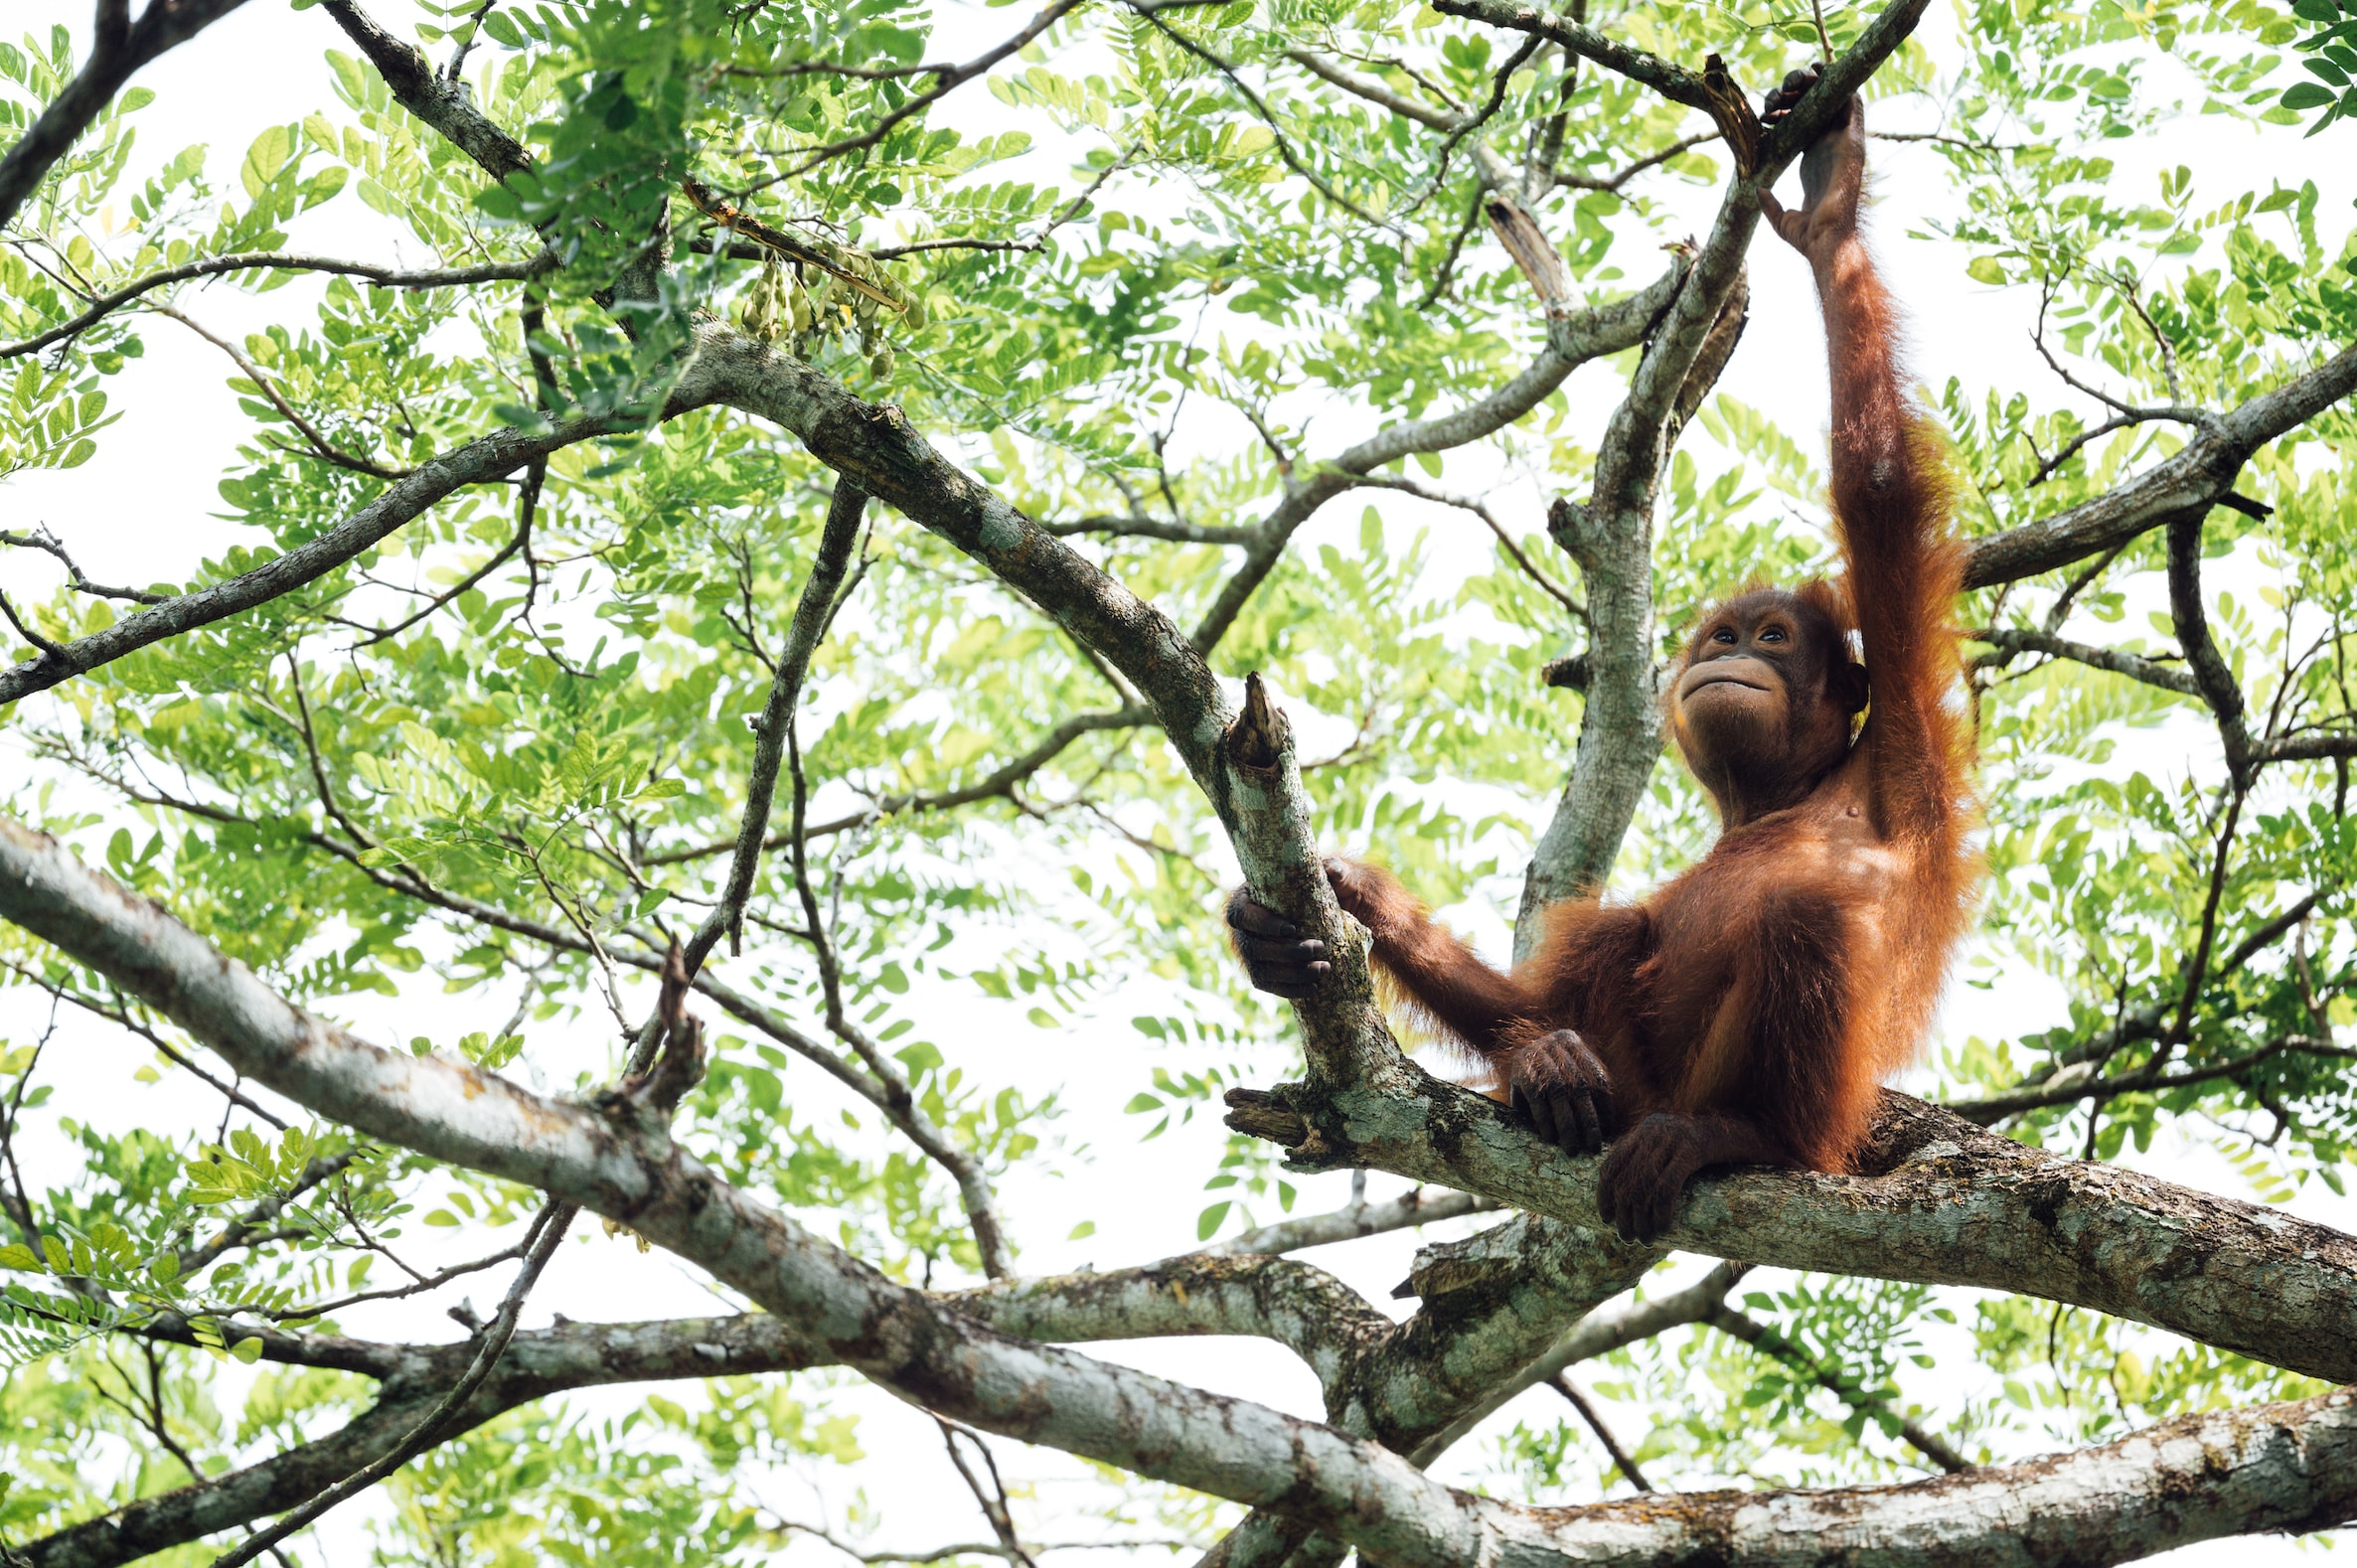

In [27]:
## gent an sample image and use the capction
import requests
from PIL import Image

img_url = 'https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

- try run the image captioning

In [28]:
# unconditional image captioning
inputs = processor(image, return_tensors="pt").to(device)

out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))
     

there is a monkey that is sitting in a tree


- now let's make an image captioning tool 

In [29]:

class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = (
        "use this tool when given the URL of an image that you'd like to be "
        "described. It will return a simple caption describing the image."
    )

    def _run(self, url: str):
        # download the image and convert to PIL object
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to(device)
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # get the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]

In [30]:

sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools

In [31]:
agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80"
}
Observation: there is a monkey that is sitting in a tree
Thought:{
    "action": "Final Answer",
    "action_input": "there is a monkey that is sitting in a tree"
}

> Finished chain.


{'input': 'What does this image show?\nhttps://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80',
 'chat_history': [HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False),
  HumanMessage(content='can you calculate the circumference of a circle that has a radius of 7.81mm', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.', additional_kwargs={}, example=False),
  HumanMessage(content='If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?', additional_kwargs={}, example=False),
  AIMessage(content='The length of the hypotenuse is approx